In [53]:
import numpy as np
import pandas as pd 
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [200]:
data_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/raw_data"
output_dir = "C:/Users/singhy/Desktop/Chicago/cps_data/inflation/output"

In [253]:
data = pd.read_excel(f"{data_dir}/atl_fed/wage-growth-data.xlsx", sheet_name = 'Average Wage Quartile', skiprows=2, header=0)
cpi = pd.read_excel(f"{data_dir}/CPI/CPIAUCSL.xls", engine='xlrd', header=0)

In [275]:
# Atlanta Fed Wage Data 
data = data.rename(columns={
    'Unnamed: 0': 'date',
    'Lowest quartile of wage distribution': 'Q1',
     '2nd quartile of wage distribution': 'Q2', 
    '3rd quartile of wage distribution': 'Q3', 
    'Highest quartile of wage distribution': 'Q4'
})

select = ['date', 'Q1', 'Q2', 'Q3', 'Q4']
df = data[select]


# CPI-U 
cpi = cpi.iloc[10:].reset_index(drop=True)

cpi = cpi.rename(columns={
                            'FRED Graph Observations': 'date', 
                            'Unnamed: 1':               'P'
})

cpi['date'] = pd.to_datetime(cpi['date'])
cpi['P'] = pd.to_numeric(cpi['P'], errors='coerce')
cpi['P_12m_change'] = cpi['P'].pct_change(periods=12) * 100




In [276]:
wage_data = data.merge(cpi, on='date', how = 'left')

In [277]:
wage_data = wage_data[wage_data['date'] >= '2015-12-01']
wage_data = wage_data[wage_data['date'] <= '2024-06-01']

In [278]:
wage_data = wage_data.drop(['Lowest half of wage distribution', 'Upper half of wage distribution'], axis = 1)
wage_data = wage_data.reset_index(drop=True)

In [279]:
wage_data['wage_index_1'] = 1
wage_data['wage_index_2'] = 1
wage_data['wage_index_3'] = 1
wage_data['wage_index_4'] = 1
wage_data['agg_wage_index'] = 1 
wage_data['P_norm'] = wage_data['P'] / wage_data['P'].iloc[0]

In [281]:
wage_data

,date,Q1,Q2,Q3,Q4,Overall,P,P_12m_change,wage_index_1,wage_index_2,wage_index_3,wage_index_4,agg_wage_index,P_norm
0,2015-12-01,3.5,3.1,3,3.2,3.1,237.761,0.638725,1,1,1,1,1,1.000000
1,2016-01-01,3.4,3.2,3,3.1,3.1,237.652,1.237503,1,1,1,1,1,0.999542
2,2016-02-01,3.5,3.2,3.1,3.1,3.2,237.336,0.847278,1,1,1,1,1,0.998212
3,2016-03-01,3.5,3.2,3,3.1,3.1,238.080,0.891616,1,1,1,1,1,1.001342
4,2016-04-01,3.6,3.2,3,3,3.1,238.992,1.172626,1,1,1,1,1,1.005177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024-02-01,5.5,5.2,5.6,5.3,5.4,311.054,3.165743,1,1,1,1,1,1.308263
99,2024-03-01,5.4,5.2,5.5,4.9,5.2,312.230,3.475131,1,1,1,1,1,1.313209
100,2024-04-01,5.6,5.2,5.6,5,5.3,313.207,3.357731,1,1,1,1,1,1.317319
101,2024-05-01,5.5,5.2,5.4,4.8,5.2,313.225,3.250210,1,1,1,1,1,1.317394


In [259]:
wage_data['q1_mom_grth'] = 1 + (wage_data['Q1']/100)/12
wage_data['q2_mom_grth'] = 1 + (wage_data['Q2']/100)/12
wage_data['q3_mom_grth'] = 1 + (wage_data['Q3']/100)/12
wage_data['q4_mom_grth'] = 1 + (wage_data['Q4']/100)/12
wage_data['agg_mom_grth'] = 1 + (wage_data['Overall']/100)/12
wage_data['P_1m_change'] = 1 + (wage_data['P_12m_change']/100)/12
wage_data['price_mom_grth'] = 1 + wage_data['P_norm'].pct_change()

In [260]:
wage_data = wage_data[wage_data['date'] >= '2016-01-01']

wage_data['nom_wage_index_1'] = wage_data['q1_mom_grth'].shift(1).cumprod()
wage_data['nom_wage_index_2'] = wage_data['q2_mom_grth'].shift(1).cumprod()
wage_data['nom_wage_index_3'] = wage_data['q3_mom_grth'].shift(1).cumprod()
wage_data['nom_wage_index_4'] = wage_data['q4_mom_grth'].shift(1).cumprod()
wage_data['agg_nom_wage_index'] = wage_data['agg_mom_grth'].shift(1).cumprod()
wage_data['price_index']      = wage_data['P_1m_change'].shift(1).cumprod()


In [261]:
wage_data['nom_wage_index_1'] = wage_data['q1_mom_grth'].cumprod()
wage_data['nom_wage_index_2'] = wage_data['q2_mom_grth'].cumprod()
wage_data['nom_wage_index_3'] = wage_data['q3_mom_grth'].cumprod()
wage_data['nom_wage_index_4'] = wage_data['q4_mom_grth'].cumprod()
wage_data['agg_nom_wage_index'] = wage_data['agg_mom_grth'].cumprod()
wage_data['price_index']      = wage_data['P_1m_change'].cumprod()
wage_data['cpi']              = wage_data['price_mom_grth'].cumprod()


In [262]:
wage_data

,date,Q1,Q2,Q3,Q4,Overall,P,P_12m_change,wage_index_1,wage_index_2,...,agg_mom_grth,P_1m_change,price_mom_grth,nom_wage_index_1,nom_wage_index_2,nom_wage_index_3,nom_wage_index_4,agg_nom_wage_index,price_index,cpi
1,2016-01-01,3.4,3.2,3,3.1,3.1,237.652,1.237503,1,1,...,1.002583,1.001031,0.999542,1.002833,1.002667,1.0025,1.002583,1.002583,1.001031,0.999542
2,2016-02-01,3.5,3.2,3.1,3.1,3.2,237.336,0.847278,1,1,...,1.002667,1.000706,0.998670,1.005758,1.00534,1.00509,1.005173,1.005257,1.001738,0.998212
3,2016-03-01,3.5,3.2,3,3.1,3.1,238.080,0.891616,1,1,...,1.002583,1.000743,1.003135,1.008692,1.008021,1.007603,1.00777,1.007854,1.002482,1.001342
4,2016-04-01,3.6,3.2,3,3,3.1,238.992,1.172626,1,1,...,1.002583,1.000977,1.003831,1.011718,1.010709,1.010122,1.010289,1.010457,1.003462,1.005177
5,2016-05-01,3.6,3.4,3,3,3.2,239.557,1.078476,1,1,...,1.002667,1.000899,1.002364,1.014753,1.013573,1.012647,1.012815,1.013152,1.004364,1.007554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024-02-01,5.5,5.2,5.6,5.3,5.4,311.054,3.165743,1,1,...,1.0045,1.002638,1.004421,1.487329,1.398333,1.366793,1.332496,1.390263,1.299485,1.308263
99,2024-03-01,5.4,5.2,5.5,4.9,5.2,312.230,3.475131,1,1,...,1.004333,1.002896,1.003781,1.494022,1.404392,1.373058,1.337937,1.396287,1.303248,1.313209
100,2024-04-01,5.6,5.2,5.6,5,5.3,313.207,3.357731,1,1,...,1.004417,1.002798,1.003129,1.500994,1.410478,1.379465,1.343512,1.402454,1.306894,1.317319
101,2024-05-01,5.5,5.2,5.4,4.8,5.2,313.225,3.250210,1,1,...,1.004333,1.002709,1.000057,1.507874,1.41659,1.385673,1.348886,1.408531,1.310434,1.317394


In [263]:
wage_data = wage_data.fillna(1)

C:\Users\singhy\AppData\Local\Temp\ipykernel_2092\1710823818.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  wage_data = wage_data.fillna(1)


In [264]:
wage_data['real_wage_index_1'] = wage_data['nom_wage_index_1'] / wage_data['price_index']
wage_data['real_wage_index_2'] = wage_data['nom_wage_index_2'] / wage_data['price_index']
wage_data['real_wage_index_3'] = wage_data['nom_wage_index_3'] / wage_data['price_index']
wage_data['real_wage_index_4'] = wage_data['nom_wage_index_4'] / wage_data['price_index']
wage_data['agg_real_wage_index'] = wage_data['agg_nom_wage_index'] / wage_data['price_index']

In [265]:
wage_data

,date,Q1,Q2,Q3,Q4,Overall,P,P_12m_change,wage_index_1,wage_index_2,...,nom_wage_index_3,nom_wage_index_4,agg_nom_wage_index,price_index,cpi,real_wage_index_1,real_wage_index_2,real_wage_index_3,real_wage_index_4,agg_real_wage_index
1,2016-01-01,3.4,3.2,3.0,3.1,3.1,237.652,1.237503,1,1,...,1.002500,1.002583,1.002583,1.001031,0.999542,1.001800,1.001634,1.001467,1.001550,1.001550
2,2016-02-01,3.5,3.2,3.1,3.1,3.2,237.336,0.847278,1,1,...,1.005090,1.005173,1.005257,1.001738,0.998212,1.004013,1.003596,1.003346,1.003429,1.003513
3,2016-03-01,3.5,3.2,3.0,3.1,3.1,238.080,0.891616,1,1,...,1.007603,1.007770,1.007854,1.002482,1.001342,1.006194,1.005525,1.005107,1.005275,1.005358
4,2016-04-01,3.6,3.2,3.0,3.0,3.1,238.992,1.172626,1,1,...,1.010122,1.010289,1.010457,1.003462,1.005177,1.008227,1.007222,1.006637,1.006804,1.006971
5,2016-05-01,3.6,3.4,3.0,3.0,3.2,239.557,1.078476,1,1,...,1.012647,1.012815,1.013152,1.004364,1.007554,1.010344,1.009169,1.008247,1.008415,1.008750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024-02-01,5.5,5.2,5.6,5.3,5.4,311.054,3.165743,1,1,...,1.366793,1.332496,1.390263,1.299485,1.308263,1.144553,1.076067,1.051797,1.025404,1.069857
99,2024-03-01,5.4,5.2,5.5,4.9,5.2,312.230,3.475131,1,1,...,1.373058,1.337937,1.396287,1.303248,1.313209,1.146384,1.077610,1.053566,1.026618,1.071390
100,2024-04-01,5.6,5.2,5.6,5.0,5.3,313.207,3.357731,1,1,...,1.379465,1.343512,1.402454,1.306894,1.317319,1.148520,1.079259,1.055529,1.028019,1.073120
101,2024-05-01,5.5,5.2,5.4,4.8,5.2,313.225,3.250210,1,1,...,1.385673,1.348886,1.408531,1.310434,1.317394,1.150667,1.081008,1.057415,1.029343,1.074859


wage_data_pre = wage_data[wage_data['date'] <= '2019-12-01']

wage_data['q1_avg_pre_mom_grth'] = wage_data_pre['q1_mom_grth'].mean()
wage_data['q2_avg_pre_mom_grth'] = wage_data_pre['q2_mom_grth'].mean()
wage_data['q3_avg_pre_mom_grth'] = wage_data_pre['q3_mom_grth'].mean()
wage_data['q4_avg_pre_mom_grth'] = wage_data_pre['q4_mom_grth'].mean()

# Set the first observation of each average growth rate column to 1
wage_data.loc[0, 'q1_avg_pre_mom_grth'] = 1
wage_data.loc[0, 'q2_avg_pre_mom_grth'] = 1
wage_data.loc[0, 'q3_avg_pre_mom_grth'] = 1
wage_data.loc[0, 'q4_avg_pre_mom_grth'] = 1

In [266]:
# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression with months since the start date
X = ((trend_data['date'].dt.year - trend_data['date'].min().year) * 12 +
     (trend_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)

# Create a dictionary to hold the predicted values for each wage index
predicted_values = {}

# Loop through each wage index to predict values
for column_name in ['real_wage_index_1', 'real_wage_index_2', 'real_wage_index_3', 'real_wage_index_4', 
                    'agg_real_wage_index', 'cpi']:
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for the entire dataset, using months since the start date
    all_dates = ((wage_data['date'].dt.year - trend_data['date'].min().year) * 12 +
                 (wage_data['date'].dt.month - trend_data['date'].min().month)).values.reshape(-1, 1)
    predicted_values[column_name] = model.predict(all_dates)

# Add the predicted columns to the DataFrame
for column_name in predicted_values:
    wage_data[f'predicted_{column_name}'] = predicted_values[column_name]
    

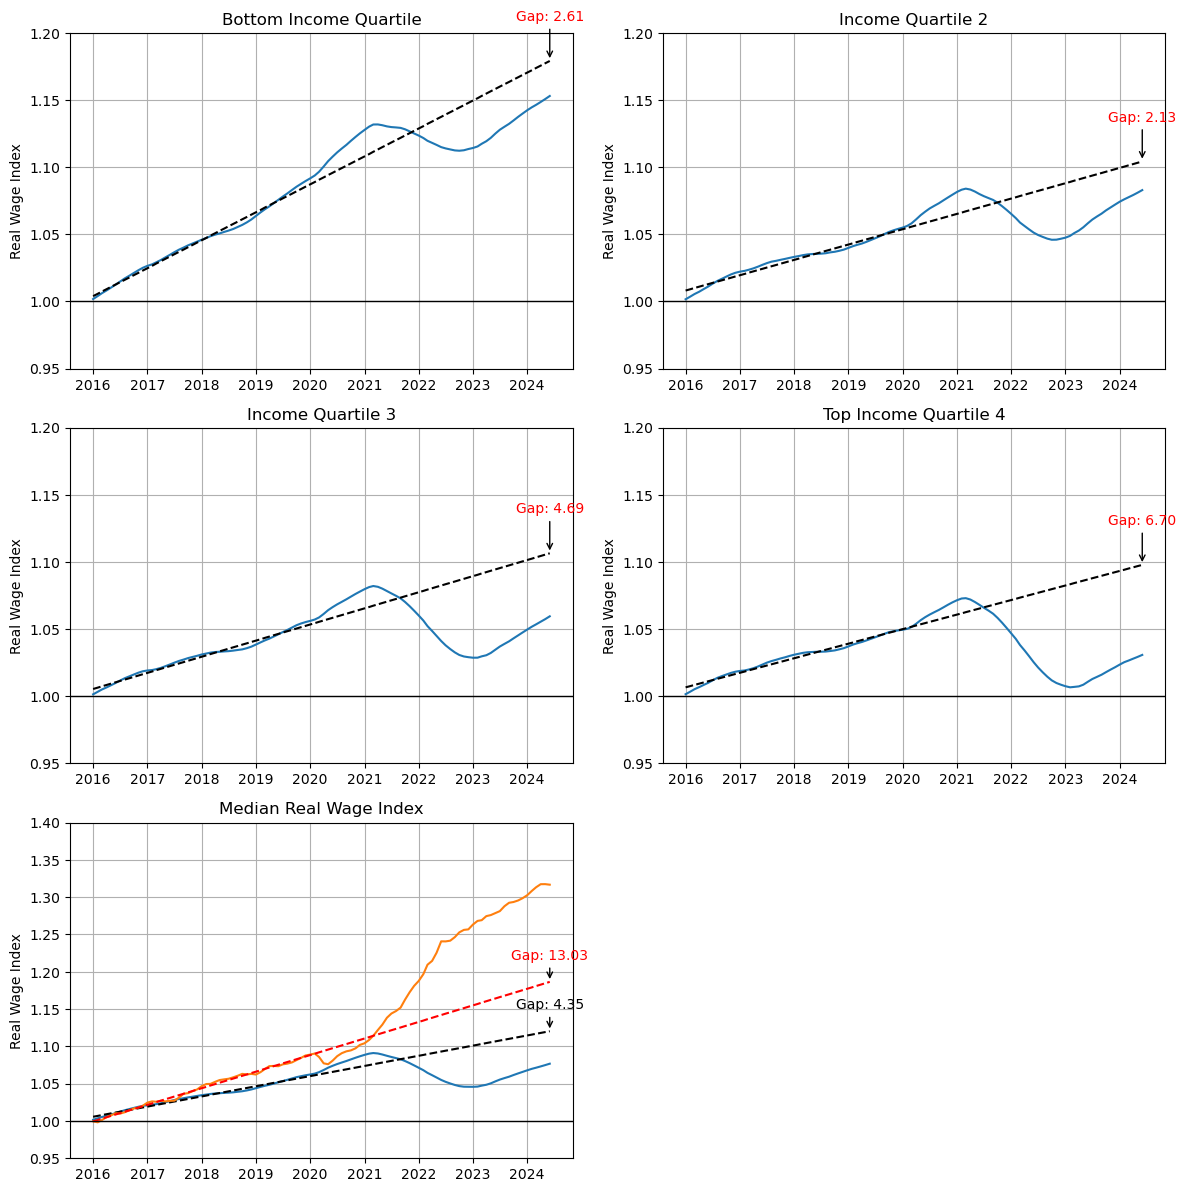

In [271]:
# Assuming wage_data is already defined and includes predicted columns
# Calculate gaps for each index
gaps = {
    'gap_1': wage_data['predicted_real_wage_index_1'].iloc[-1] - wage_data['real_wage_index_1'].iloc[-1],
    'gap_2': wage_data['predicted_real_wage_index_2'].iloc[-1] - wage_data['real_wage_index_2'].iloc[-1],
    'gap_3': wage_data['predicted_real_wage_index_3'].iloc[-1] - wage_data['real_wage_index_3'].iloc[-1],
    'gap_4': wage_data['predicted_real_wage_index_4'].iloc[-1] - wage_data['real_wage_index_4'].iloc[-1],
    'gap_agg': wage_data['predicted_agg_real_wage_index'].iloc[-1] - wage_data['agg_real_wage_index'].iloc[-1],
    'gap_price': wage_data['cpi'].iloc[-1] - wage_data['predicted_cpi'].iloc[-1]
}

# Create five separate plots
plt.figure(figsize=(12, 12))

# Plot for real_wage_index_1
plt.subplot(3, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.grid()
plt.annotate(f'Gap: {gaps["gap_1"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_2
plt.subplot(3, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.grid()
plt.annotate(f'Gap: {gaps["gap_2"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_3
plt.subplot(3, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.grid()
plt.annotate(f'Gap: {gaps["gap_3"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_4
plt.subplot(3, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.grid()
plt.annotate(f'Gap: {gaps["gap_4"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for agg_real_wage_index
plt.subplot(3, 2, 5)
plt.plot(wage_data['date'], wage_data['agg_real_wage_index'], label='Real Wage Index (Aggregate)')
plt.plot(wage_data['date'], wage_data['predicted_agg_real_wage_index'], color='black', linestyle='--', label='Predicted', linewidth=1.5)



plt.plot(wage_data['date'], wage_data['cpi'])
plt.plot(wage_data['date'], wage_data['predicted_cpi'], color='red', linestyle='--', label='Predicted', linewidth=1.5)

plt.title('Median Real Wage Index')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.4)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.grid()

plt.annotate(f'Gap: {gaps["gap_price"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_cpi'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_cpi'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='red', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

plt.annotate(f'Gap: {gaps["gap_agg"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_agg_real_wage_index'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_agg_real_wage_index'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='black', ha='center')

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()

In [273]:
main = ['date', 'cpi', 'predicted_cpi', 
                'agg_real_wage_index', 'predicted_agg_real_wage_index', 
                'real_wage_index_1', 'predicted_real_wage_index_1', 
                'real_wage_index_2', 'predicted_real_wage_index_2', 
                'real_wage_index_3', 'predicted_real_wage_index_3', 
                'real_wage_index_4', 'predicted_real_wage_index_4']

final = wage_data[main]


In [274]:
final

,date,cpi,predicted_cpi,agg_real_wage_index,predicted_agg_real_wage_index,real_wage_index_1,predicted_real_wage_index_1,real_wage_index_2,predicted_real_wage_index_2,real_wage_index_3,predicted_real_wage_index_3,real_wage_index_4,predicted_real_wage_index_4
1,2016-01-01,0.999542,0.999436,1.001550,1.005663,1.001800,1.003970,1.001634,1.008131,1.001467,1.005441,1.001550,1.006673
2,2016-02-01,0.998212,1.001287,1.003513,1.006798,1.004013,1.005704,1.003596,1.009082,1.003346,1.006441,1.003429,1.007575
3,2016-03-01,1.001342,1.003138,1.005358,1.007932,1.006194,1.007437,1.005525,1.010033,1.005107,1.007441,1.005275,1.008478
4,2016-04-01,1.005177,1.004989,1.006971,1.009067,1.008227,1.009171,1.007222,1.010984,1.006637,1.008441,1.006804,1.009380
5,2016-05-01,1.007554,1.006840,1.008750,1.010202,1.010344,1.010904,1.009169,1.011936,1.008247,1.009442,1.008415,1.010283
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024-02-01,1.308263,1.178991,1.069857,1.115728,1.144553,1.172116,1.076067,1.100395,1.051797,1.102461,1.025404,1.094224
99,2024-03-01,1.313209,1.180842,1.071390,1.116863,1.146384,1.173850,1.077610,1.101346,1.053566,1.103461,1.026618,1.095126
100,2024-04-01,1.317319,1.182694,1.073120,1.117997,1.148520,1.175583,1.079259,1.102298,1.055529,1.104462,1.028019,1.096029
101,2024-05-01,1.317394,1.184545,1.074859,1.119132,1.150667,1.177317,1.081008,1.103249,1.057415,1.105462,1.029343,1.096931


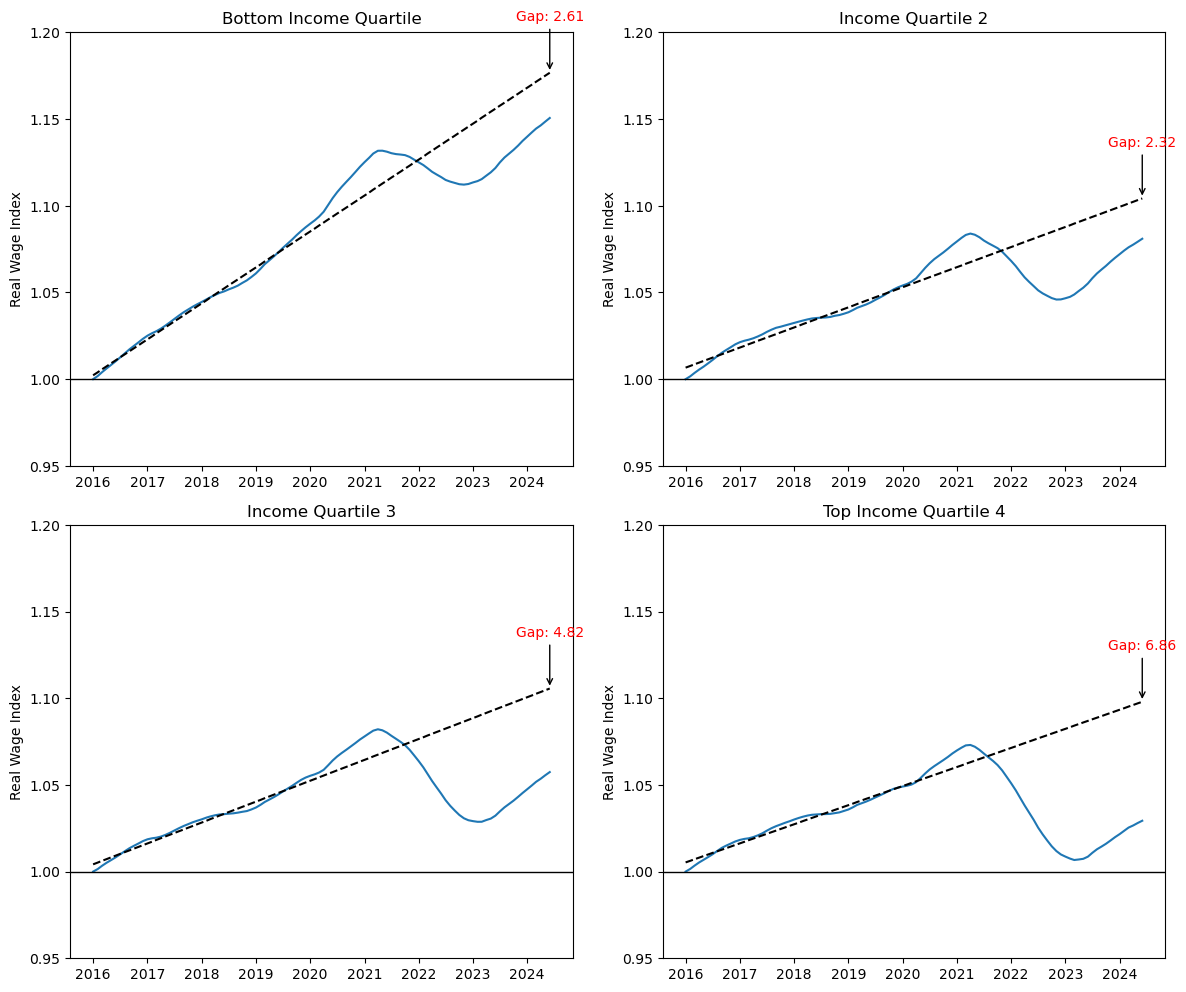

In [86]:
# Assuming wage_data is already defined and includes predicted columns
# Calculate gaps for each index
gaps = {
    'gap_1': wage_data['predicted_real_wage_index_1'].iloc[-1] - wage_data['real_wage_index_1'].iloc[-1],
    'gap_2': wage_data['predicted_real_wage_index_2'].iloc[-1] - wage_data['real_wage_index_2'].iloc[-1],
    'gap_3': wage_data['predicted_real_wage_index_3'].iloc[-1] - wage_data['real_wage_index_3'].iloc[-1],
    'gap_4': wage_data['predicted_real_wage_index_4'].iloc[-1] - wage_data['real_wage_index_4'].iloc[-1],
}

# Create four separate plots
plt.figure(figsize=(12, 10))

# Plot for real_wage_index_1
plt.subplot(2, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_1"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_2
plt.subplot(2, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_2"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_3
plt.subplot(2, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_3"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_4
plt.subplot(2, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_4"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()


In [389]:
# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression
X = (trend_data['date'] - trend_data['date'].min()).dt.days.values.reshape(-1, 1)  # Days since start

# Create a dictionary to hold the predicted values for each wage index
predicted_values = {}

# Loop through each wage index to predict values
for i in range(1, 5):
    column_name = f'real_wage_index_{i}'
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict for the entire dataset
    all_dates = (wage_data['date'] - trend_data['date'].min()).dt.days.values.reshape(-1, 1)
    predicted_values[column_name] = model.predict(all_dates)

# Add the predicted columns to the DataFrame
for i in range(1, 5):
    wage_data[f'predicted_real_wage_index_{i}'] = predicted_values[f'real_wage_index_{i}']

In [390]:
wage_data

,date,Q1,Q2,Q3,Q4,Overall,P,wage_index_1,wage_index_2,wage_index_3,...,real_wage_index_4,q1_avg_pre_mom_grth,q2_avg_pre_mom_grth,q3_avg_pre_mom_grth,q4_avg_pre_mom_grth,est_real_wage_index_1,predicted_real_wage_index_1,predicted_real_wage_index_2,predicted_real_wage_index_3,predicted_real_wage_index_4
0,2016-01-01,3.4,3.2,3.0,3.1,3.1,237.652,1,1,1,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.996443,1.000836,0.998406,0.999501
1,2016-02-01,3.5,3.2,3.1,3.1,3.2,237.336,1,1,1,...,1.003918,1.003387,1.002693,1.002717,1.002594,1.003387,0.998122,1.001745,0.999352,1.000360
2,2016-03-01,3.5,3.2,3.0,3.1,3.1,238.080,1,1,1,...,1.003366,1.003387,1.002693,1.002717,1.002594,1.006786,0.999693,1.002595,1.000238,1.001164
3,2016-04-01,3.6,3.2,3.0,3.0,3.1,238.992,1,1,1,...,1.002120,1.003387,1.002693,1.002717,1.002594,1.010196,1.001372,1.003503,1.001185,1.002023
4,2016-05-01,3.6,3.4,3.0,3.0,3.2,239.557,1,1,1,...,1.002255,1.003387,1.002693,1.002717,1.002594,1.013618,1.002997,1.004382,1.002101,1.002854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,2024-02-01,5.5,5.2,5.6,5.3,5.4,311.054,1,1,1,...,1.013579,1.003387,1.002693,1.002717,1.002594,1.388187,1.156377,1.087378,1.088582,1.081329
98,2024-03-01,5.4,5.2,5.5,4.9,5.2,312.230,1,1,1,...,1.014222,1.003387,1.002693,1.002717,1.002594,1.392889,1.157948,1.088228,1.089468,1.082133
99,2024-04-01,5.6,5.2,5.6,5.0,5.3,313.207,1,1,1,...,1.015186,1.003387,1.002693,1.002717,1.002594,1.397607,1.159627,1.089137,1.090414,1.082992
100,2024-05-01,5.5,5.2,5.4,4.8,5.2,313.225,1,1,1,...,1.019358,1.003387,1.002693,1.002717,1.002594,1.402341,1.161252,1.090016,1.091331,1.083823


In [345]:
gaps = {
    'gap_1': np.log(wage_data['predicted_real_wage_index_1'].iloc[-1]) - np.log(wage_data['real_wage_index_1'].iloc[-1]),
    'gap_2': np.log(wage_data['predicted_real_wage_index_2'].iloc[-1]) - np.log(wage_data['real_wage_index_2'].iloc[-1]),
    'gap_3': np.log(wage_data['predicted_real_wage_index_3'].iloc[-1]) - np.log(wage_data['real_wage_index_3'].iloc[-1]),
    'gap_4': np.log(wage_data['predicted_real_wage_index_4'].iloc[-1]) - np.log(wage_data['real_wage_index_4'].iloc[-1]),
}


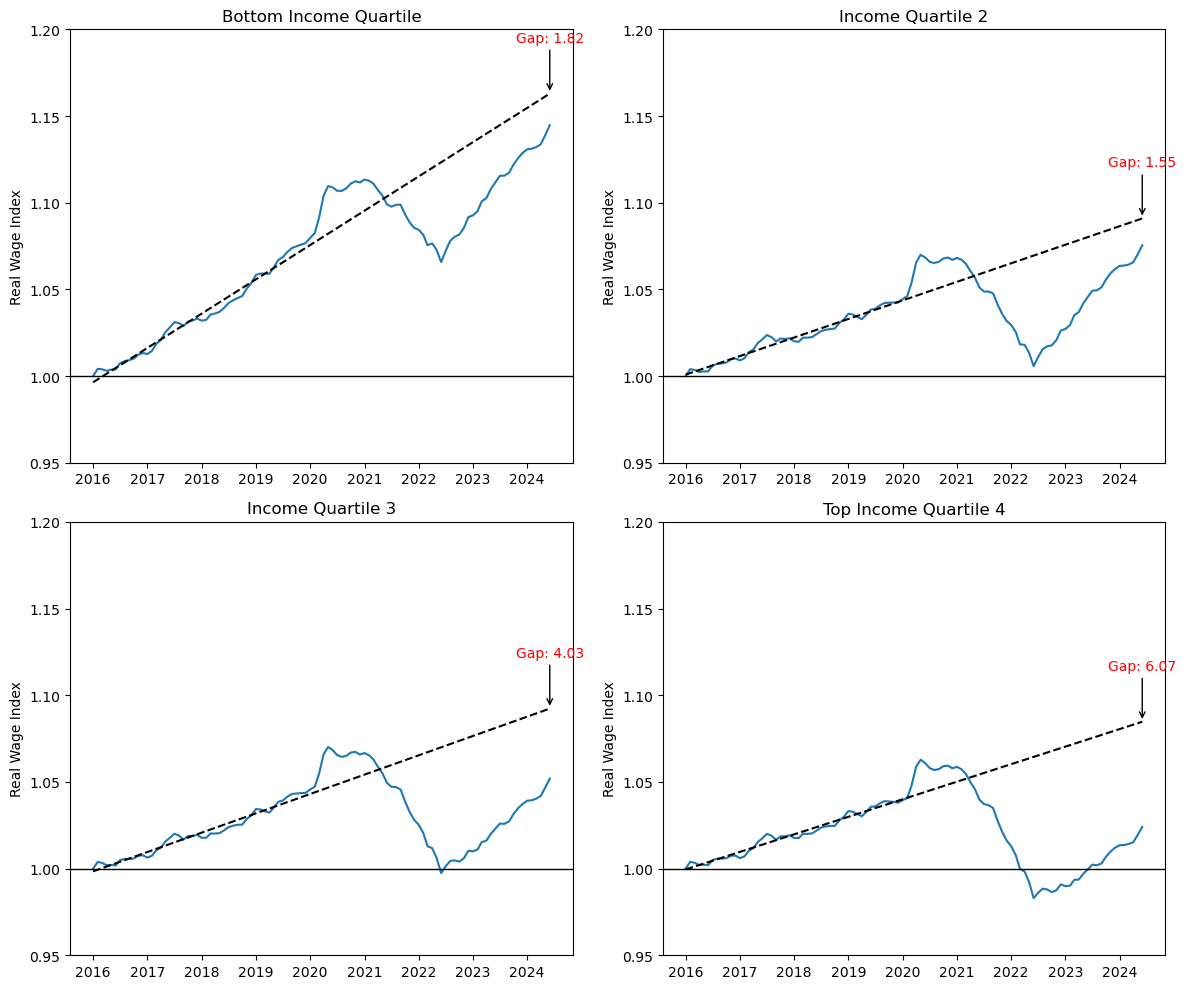

In [346]:


# Assuming wage_data is already defined and includes predicted columns
# Calculate gaps for each index
gaps = {
    'gap_1': wage_data['predicted_real_wage_index_1'].iloc[-1] - wage_data['real_wage_index_1'].iloc[-1],
    'gap_2': wage_data['predicted_real_wage_index_2'].iloc[-1] - wage_data['real_wage_index_2'].iloc[-1],
    'gap_3': wage_data['predicted_real_wage_index_3'].iloc[-1] - wage_data['real_wage_index_3'].iloc[-1],
    'gap_4': wage_data['predicted_real_wage_index_4'].iloc[-1] - wage_data['real_wage_index_4'].iloc[-1],
}

# Create four separate plots
plt.figure(figsize=(12, 10))

# Plot for real_wage_index_1
plt.subplot(2, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_1"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_2
plt.subplot(2, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_2"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_3
plt.subplot(2, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_3"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Plot for real_wage_index_4
plt.subplot(2, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_4"] * 100:.2f}', 
             xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.03), 
             arrowprops=dict(facecolor='black', arrowstyle='->'), 
             fontsize=10, color='red', ha='center')

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()


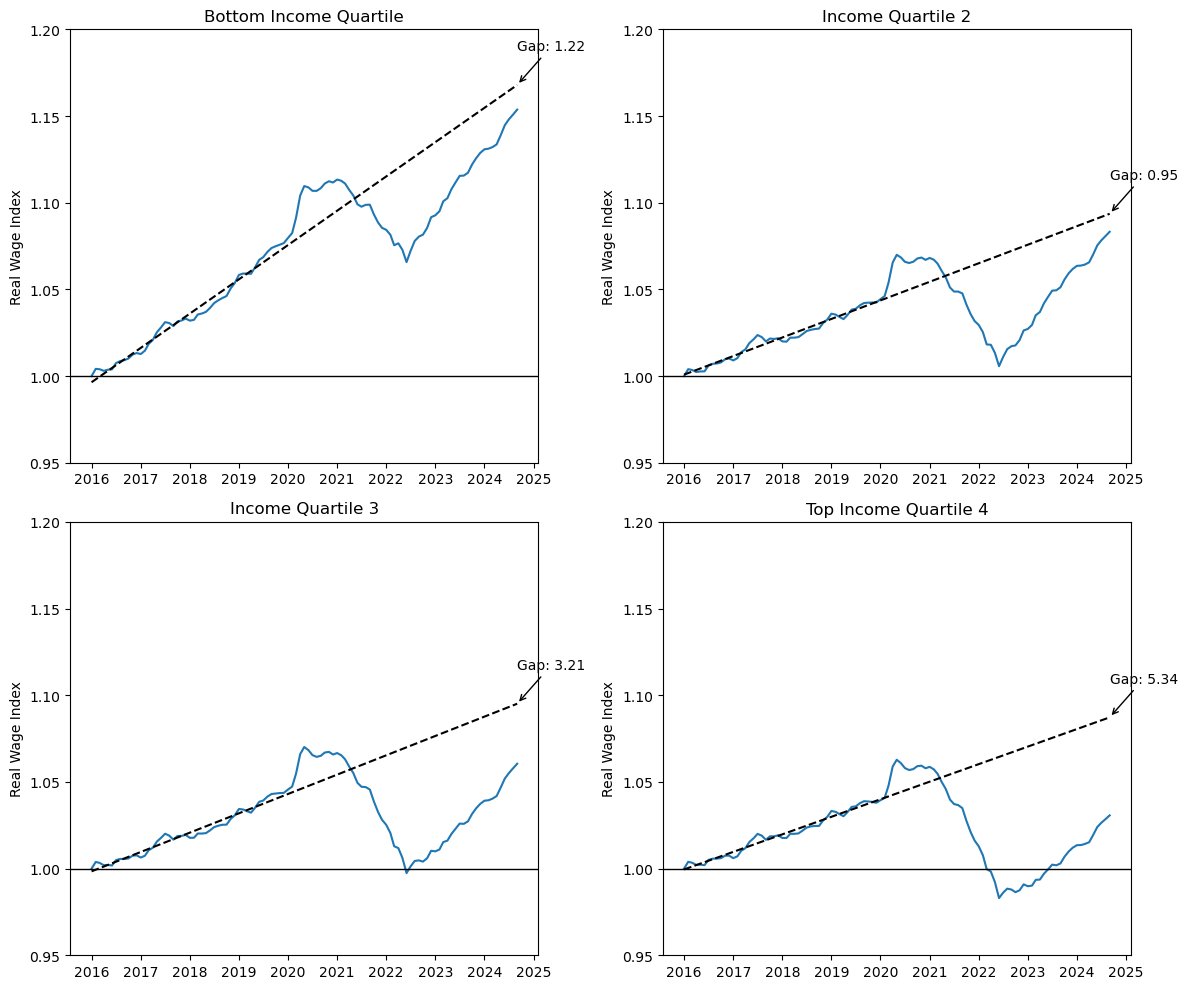

In [272]:


# Create four separate plots
plt.figure(figsize=(12, 10))

# Plot for real_wage_index_1
plt.subplot(2, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_1"]*100:.2f}', xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1] + 0.02), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Plot for real_wage_index_2
plt.subplot(2, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_2"]*100:.2f}', xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1] + 0.02), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Plot for real_wage_index_3
plt.subplot(2, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_3"]*100:.2f}', xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1] + 0.02), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Plot for real_wage_index_4
plt.subplot(2, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
plt.annotate(f'Gap: {gaps["gap_4"]*100:.2f}', xy=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1]), 
             xytext=(wage_data['date'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1] + 0.02), 
             arrowprops=dict(facecolor='black', arrowstyle='->'))

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()

TypeError: unsupported operand type(s) for +: 'Timestamp' and 'float'

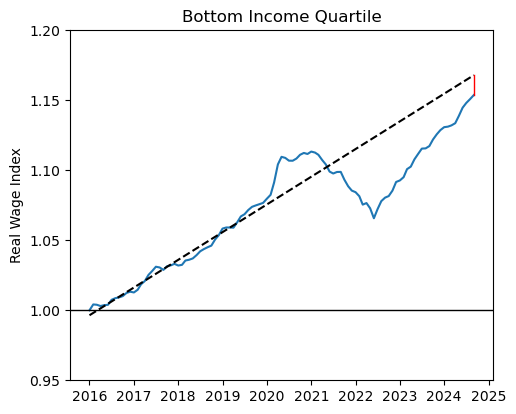

In [270]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming wage_data is already defined and includes predicted columns
# Calculate gaps for each index
gaps = {
    'gap_1': np.log(wage_data['predicted_real_wage_index_1'].iloc[-1]) - np.log(wage_data['real_wage_index_1'].iloc[-1]),
    'gap_2': np.log(wage_data['predicted_real_wage_index_2'].iloc[-1]) - np.log(wage_data['real_wage_index_2'].iloc[-1]),
    'gap_3': np.log(wage_data['predicted_real_wage_index_3'].iloc[-1]) - np.log(wage_data['real_wage_index_3'].iloc[-1]),
    'gap_4': np.log(wage_data['predicted_real_wage_index_4'].iloc[-1]) - np.log(wage_data['real_wage_index_4'].iloc[-1]),
}

# Create four separate plots
plt.figure(figsize=(12, 10))

# Function to draw curly line
def draw_curly_line(x, y_actual, y_predicted):
    plt.plot([x, x], [y_actual, y_predicted], color='red', linestyle='-', linewidth=1)
    # Draw curly line
    for i in range(5):
        plt.plot([x, x + 0.02 * (-1) ** i], [y_actual + (i - 2) * 0.01, y_actual + (i - 2) * 0.01], color='red', linewidth=1)

# Plot for real_wage_index_1
plt.subplot(2, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
draw_curly_line(wage_data['date'].iloc[-1], wage_data['real_wage_index_1'].iloc[-1], wage_data['predicted_real_wage_index_1'].iloc[-1])

# Plot for real_wage_index_2
plt.subplot(2, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
draw_curly_line(wage_data['date'].iloc[-1], wage_data['real_wage_index_2'].iloc[-1], wage_data['predicted_real_wage_index_2'].iloc[-1])

# Plot for real_wage_index_3
plt.subplot(2, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
draw_curly_line(wage_data['date'].iloc[-1], wage_data['real_wage_index_3'].iloc[-1], wage_data['predicted_real_wage_index_3'].iloc[-1])

# Plot for real_wage_index_4
plt.subplot(2, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=1
draw_curly_line(wage_data['date'].iloc[-1], wage_data['real_wage_index_4'].iloc[-1], wage_data['predicted_real_wage_index_4'].iloc[-1])

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()


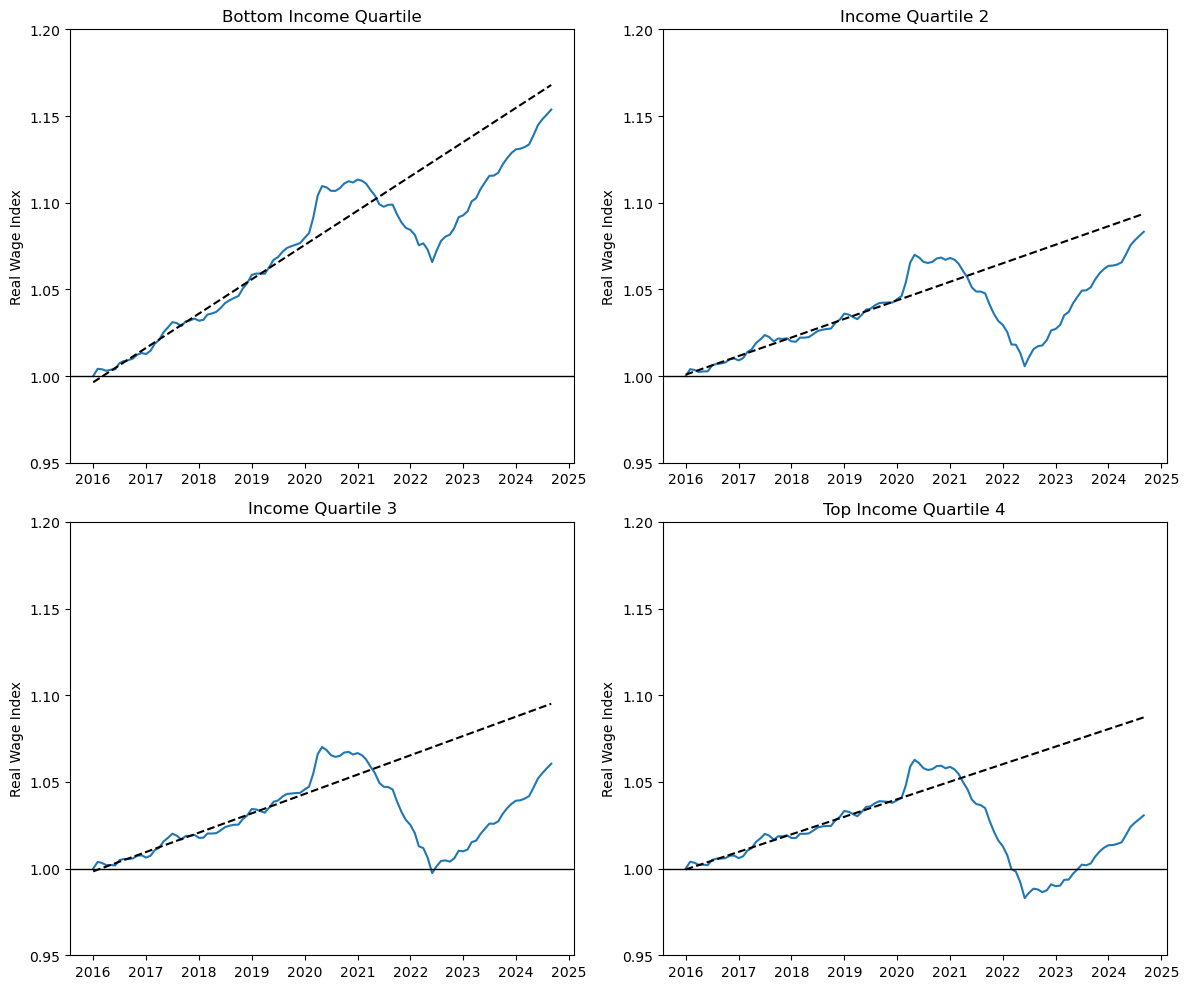

In [235]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming wage_data is already defined and includes predicted columns
# Create four separate plots
plt.figure(figsize=(12, 10))

# Plot for real_wage_index_1
plt.subplot(2, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'], label='Real Wage Index 1')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_1'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Bottom Income Quartile')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=0

# Plot for real_wage_index_2
plt.subplot(2, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'], label='Real Wage Index 2')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_2'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 2')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=0

# Plot for real_wage_index_3
plt.subplot(2, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'], label='Real Wage Index 3')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_3'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Income Quartile 3')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=0


# Plot for real_wage_index_4
plt.subplot(2, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'], label='Real Wage Index 4')
plt.plot(wage_data['date'], wage_data['predicted_real_wage_index_4'], color='black', linestyle='--', label='Predicted', linewidth=1.5)
plt.title('Top Income Quartile 4')
plt.ylabel('Real Wage Index')
plt.ylim(0.95, 1.2)
plt.xticks(rotation=0)
plt.axhline(y=1, color='black', linewidth=1)  # Horizontal line at y=0

# Adjust layout
plt.tight_layout()  
plt.savefig(f"{output_dir}/figures/wage_index_trends.pdf")
plt.show()


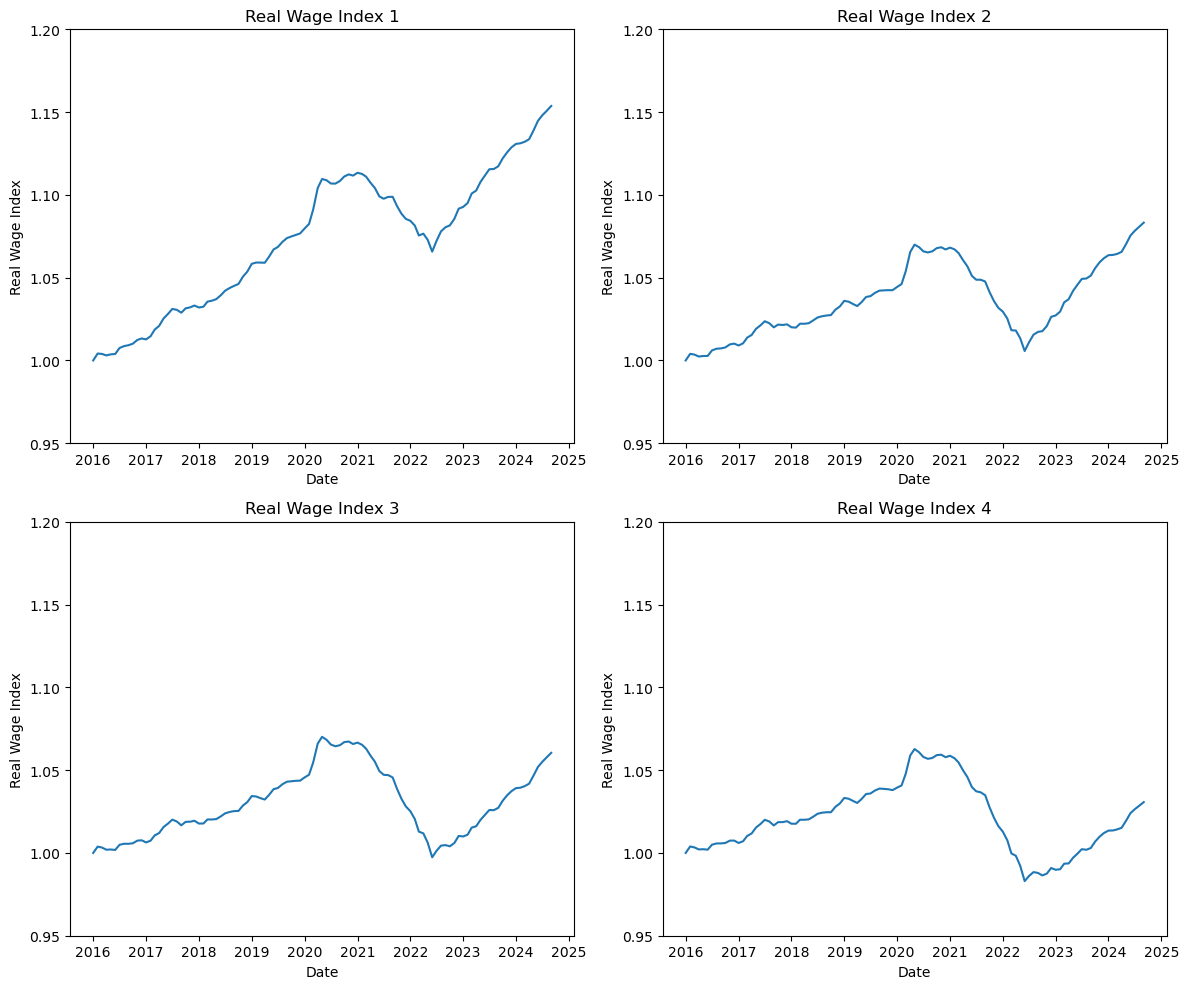

In [209]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming wage_data is already defined

# Create four separate plots
plt.figure(figsize=(12, 10))

# Plot for real_wage_index_1
plt.subplot(2, 2, 1)
plt.plot(wage_data['date'], wage_data['real_wage_index_1'])
plt.title('Real Wage Index 1')
plt.xlabel('Date')
plt.ylabel('Real Wage Index')
plt.ylim(.95,1.2)
plt.xticks(rotation=0)

# Plot for real_wage_index_2
plt.subplot(2, 2, 2)
plt.plot(wage_data['date'], wage_data['real_wage_index_2'])
plt.title('Real Wage Index 2')
plt.xlabel('Date')
plt.ylabel('Real Wage Index')
plt.ylim(.95,1.2)
plt.xticks(rotation=0)

# Plot for real_wage_index_3
plt.subplot(2, 2, 3)
plt.plot(wage_data['date'], wage_data['real_wage_index_3'])
plt.title('Real Wage Index 3')
plt.xlabel('Date')
plt.ylabel('Real Wage Index')
plt.ylim(.95,1.2)
plt.xticks(rotation=0)

# Plot for real_wage_index_4
plt.subplot(2, 2, 4)
plt.plot(wage_data['date'], wage_data['real_wage_index_4'])
plt.title('Real Wage Index 4')
plt.xlabel('Date')
plt.ylabel('Real Wage Index')
plt.ylim(.95,1.2)
plt.xticks(rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


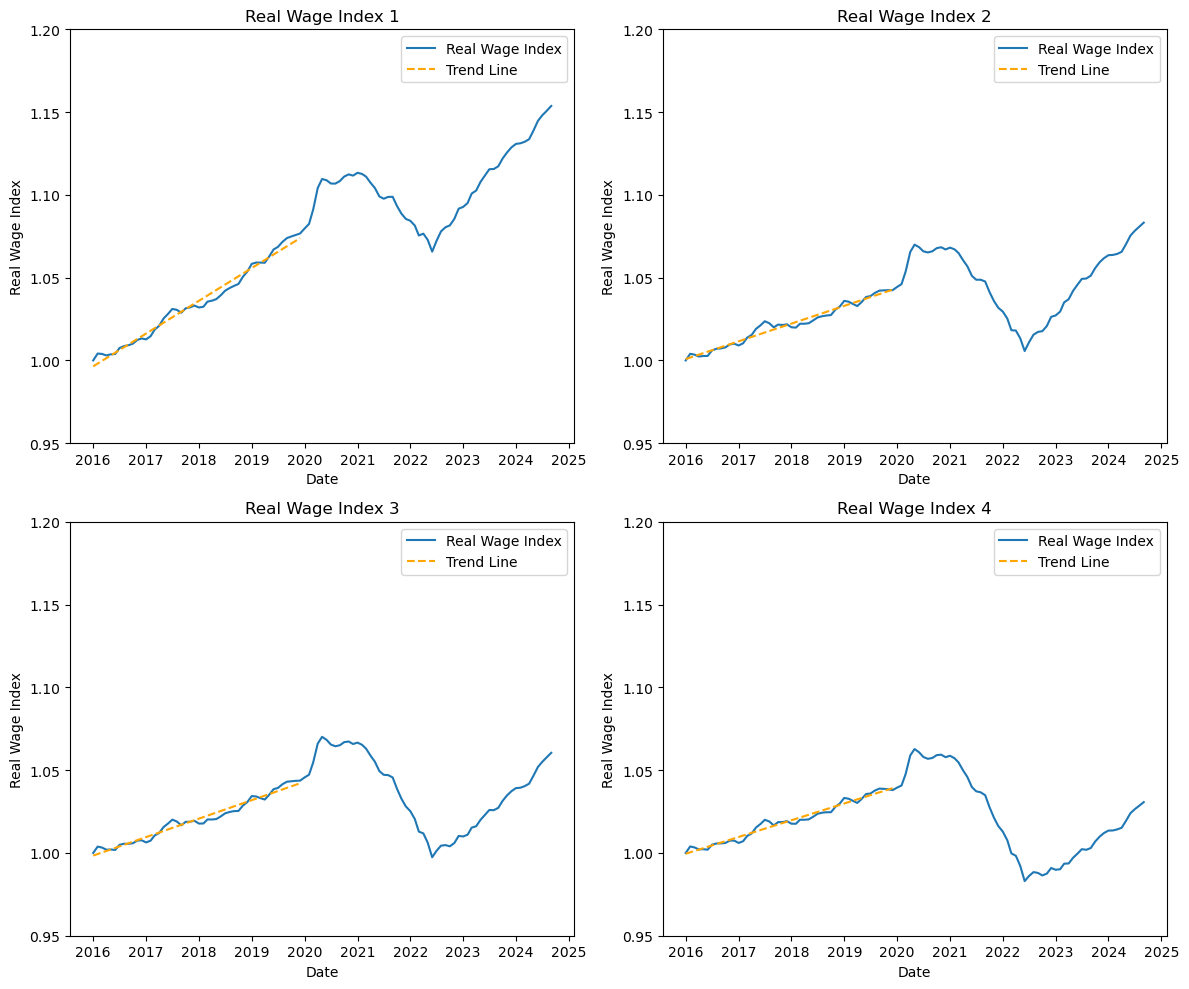

In [211]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming wage_data is already defined
# Convert 'date' to datetime format if it's not already
wage_data['date'] = pd.to_datetime(wage_data['date'])

# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression
X = (trend_data['date'] - trend_data['date'].min()).dt.days.values.reshape(-1, 1)  # Days since start
trend_lines = {}

# Create four separate plots with trend lines
plt.figure(figsize=(12, 10))

for i in range(1, 5):
    # Get current wage index
    column_name = f'real_wage_index_{i}'
    
    # Plot the wage index
    plt.subplot(2, 2, i)
    plt.plot(wage_data['date'], wage_data[column_name], label='Real Wage Index')
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Predict the trend line
    trend_line = model.predict(X)
    
    # Plot the trend line
    plt.plot(trend_data['date'], trend_line, color='orange', linestyle='--', label='Trend Line')
    
    # Title and labels
    plt.title(f'Real Wage Index {i}')
    plt.xlabel('Date')
    plt.ylabel('Real Wage Index')
    plt.ylim(0.95, 1.2)
    plt.xticks(rotation=0)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

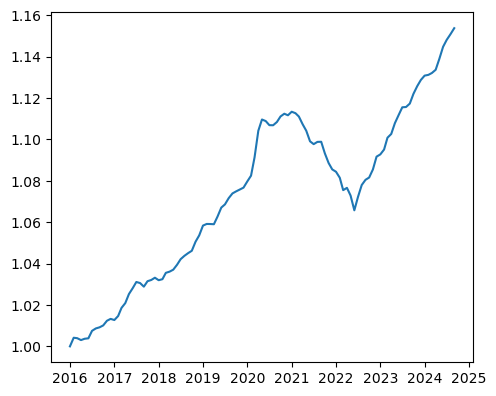

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming wage_data is already defined
# Convert 'date' to datetime format if it's not already
wage_data['date'] = pd.to_datetime(wage_data['date'])

# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression
X = (trend_data['date'] - trend_data['date'].min()).dt.days.values.reshape(-1, 1)  # Days since start

# Create four separate plots with extrapolated trend lines
plt.figure(figsize=(12, 10))

for i in range(1, 5):
    # Get current wage index
    column_name = f'real_wage_index_{i}'
    
    # Plot the wage index
    plt.subplot(2, 2, i)
    plt.plot(wage_data['date'], wage_data[column_name], label='Real Wage Index')
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Prepare dates for extrapolation
    all_dates = wage_data['date'].values
    start_date_as_days = (trend_data['date'].min() - trend_data['date'].min()).days  # This will be 0
    X_full = (all_dates - trend_data['date'].min()).astype('timedelta64[D]').astype(int).reshape(-1, 1)

    # Predict the trend line for all dates
    trend_line = model.predict(X_full)
    
    # Plot the extrapolated trend line in black
    plt.plot(all_dates, trend_line, color='black', linestyle='--', label='Extrapolated Trend Line')
    
    # Title and labels
    plt.title(f'Real Wage Index {i}')
    plt.xlabel('Date')
    plt.ylabel('Real Wage Index')
    plt.ylim(0.95, 1.2)
    plt.xticks(rotation=0)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

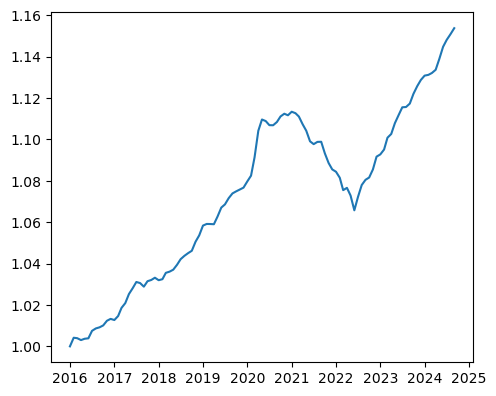

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import numpy as np

# Assuming wage_data is already defined
# Convert 'date' to datetime format if it's not already
wage_data['date'] = pd.to_datetime(wage_data['date'])

# Define the date range for the trend line
start_date = '2016-01-01'
end_date = '2019-12-31'

# Filter the data for the trend calculation
trend_data = wage_data[(wage_data['date'] >= start_date) & (wage_data['date'] <= end_date)]

# Prepare for linear regression
X = (trend_data['date'] - trend_data['date'].min()).dt.days.values.reshape(-1, 1)  # Days since start

# Create four separate plots with extrapolated trend lines
plt.figure(figsize=(12, 10))

for i in range(1, 5):
    # Get current wage index
    column_name = f'real_wage_index_{i}'
    
    # Plot the wage index
    plt.subplot(2, 2, i)
    plt.plot(wage_data['date'], wage_data[column_name], label='Real Wage Index')
    
    # Fit linear regression model
    y = trend_data[column_name].values
    model = LinearRegression()
    model.fit(X, y)
    
    # Prepare dates for extrapolation
    all_dates = wage_data['date'].values
    X_full = (all_dates - trend_data['date'].min()).astype('timedelta64[D]').astype(int).reshape(-1, 1)
    
    # Predict the trend line for all dates
    trend_line = model.predict(X_full)
    
    # Plot the extrapolated trend line in black
    plt.plot(all_dates, trend_line, color='black', linestyle='--', label='Extrapolated Trend Line')
    
    # Title and labels
    plt.title(f'Real Wage Index {i}')
    plt.xlabel('Date')
    plt.ylabel('Real Wage Index')
    plt.ylim(0.95, 1.2)
    plt.xticks(rotation=0)
    plt.legend()

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
cpi = cpi.iloc[10:].reset_index(drop=True)

cpi = cpi.rename(columns={
                            'FRED Graph Observations': 'date', 
                            'Unnamed: 1':               'P'
})

cpi['date'] = pd.to_datetime(cpi['date'])

In [24]:
data = data.rename(columns={
    'Unnamed: 0': 'date',
    'Lowest quartile of wage distribution': 'Q1',
     '2nd quartile of wage distribution': 'Q2', 
    '3rd quartile of wage distribution': 'Q3', 
    'Highest quartile of wage distribution': 'Q4'
})

In [30]:
select = ['date', 'Q1', 'Q2', 'Q3', 'Q4']
df = data[select]

In [39]:
df['date']

0     1997-01-01
1     1997-02-01
2     1997-03-01
3     1997-04-01
4     1997-05-01
         ...    
328   2024-05-01
329   2024-06-01
330   2024-07-01
331   2024-08-01
332   2024-09-01
Name: date, Length: 333, dtype: datetime64[ns]